In [3]:
import numpy as np
import scipy
import time
from collections import defaultdict
from scipy.optimize.linesearch import scalar_search_wolfe2


class LineSearchTool(object):
    """ Line search tool for adaptively tuning the step size of the algorithm.
    method : String containing 'Wolfe', 'Armijo' or 'Constant'
        Method of tuning step-size.
        Must be be one of the following strings:
            - 'Wolfe' -- enforce strong Wolfe conditions;
            - 'Armijo" -- adaptive Armijo rule;
            - 'Constant' -- constant step size.
    kwargs :
        Additional parameters of line_search method:
        If method == 'Wolfe':
            c1, c2 : Constants for strong Wolfe conditions
        If method == 'Armijo':
            c1 : Constant for Armijo rule
            alpha_0 : Starting point for the backtracking procedure.
        If method == 'Constant':
            c : The step size which is returned on every step. """
    def __init__(self, method='Wolfe', **kwargs):
        self._method = method
        if self._method == 'Wolfe':
            self.c1 = kwargs.get('c1', 1e-4)
            self.c2 = kwargs.get('c2', 0.9)
            self.alpha_0 = kwargs.get('alpha_0', 1.0)
        elif self._method == 'Armijo':
            self.c1 = kwargs.get('c1', 1e-4)
            self.alpha_0 = kwargs.get('alpha_0', 1.0)
        elif self._method == 'Constant':
            self.c = kwargs.get('c', 1.0)
        else:
            raise ValueError('Unknown method {}'.format(method))

    @classmethod
    def from_dict(cls, options):
        if type(options) != dict:
            raise TypeError('LineSearchTool initializer must be of type dict')
        return cls(**options)

    def to_dict(self):
        return self.__dict__

    def line_search(self, oracle, x_k, d_k, previous_alpha=None):
        """ Finds the step size alpha for a given starting point x_k
        and for a given search direction d_k that satisfies necessary
        conditions for phi(alpha) = oracle.func(x_k + alpha * d_k).
        Parameters
        ----------
        oracle : BaseSmoothOracle-descendant object
            Oracle with .func_directional() and .grad_directional() methods implemented for computing
            function values and its directional derivatives.
        x_k : np.array
            Starting point
        d_k : np.array
            Search direction
        previous_alpha : float or None
            Starting point to use instead of self.alpha_0 to keep the progress from
             previous steps. If None, self.alpha_0, is used as a starting point.
        Returns
        -------
        alpha : float or None if failure.  Chosen step size """

        if self._method != 'Constant':
            if previous_alpha:
                alpha = previous_alpha
            else:
                alpha = self.alpha_0
                
        def phi(alpha):
            return oracle.func_directional(x_k, d_k, alpha)
        
        def grad_phi(alpha):
            return oracle.grad_directional(x_k, d_k, alpha) 
        
        if self._method == 'Constant':
            return self.c
        
        elif self._method == 'Armijo':
            # your code here
            c1 = self.c1
            while phi(alpha) > phi(0) + c1 * alpha * grad_phi(0):
                alpha = alpha / 2
            return alpha
        
        elif self._method == 'Wolfe':
            # your code here
            c1 = self.c1
            c2 = self.c2
            alpha = scalar_search_wolfe2(phi=phi, derphi=grad_phi, c1=c1, c2 = c2)[0]
            if alpha:
                return alpha
            else:
                while phi(alpha) > phi(0) + c1 * alpha * grad_phi(0):
                    alpha = alpha / 2
                return alpha
    
def get_line_search_tool(line_search_options=None):
    if line_search_options:
        if type(line_search_options) is LineSearchTool:
            return line_search_options
        else:
            return LineSearchTool.from_dict(line_search_options)
    else:
        return LineSearchTool()
    

class GradientDescent(object):
    """
    Gradient descent optimization algorithm.
    
    oracle : BaseSmoothOracle-descendant object
        Oracle with .func() and .grad() methods implemented for computing
        function value and its gradient respectively.
    x_0 : np.array
        Starting point for optimization algorithm
    tolerance : float
        Epsilon value for stopping criterion.
    line_search_options : dict, LineSearchTool or None
        Dictionary with line search options. See LineSearchTool class for details.
    """
    def __init__(self, oracle, x_0, tolerance=1e-10, line_search_options=None):
        self.oracle = oracle
        self.x_0 = x_0.copy()
        self.tolerance = tolerance
        self.line_search_tool = get_line_search_tool(line_search_options)
        self.hist = defaultdict(list)
        # maybe more of your code here
        
    
    def run(self, max_iter=100):
        """
        Runs gradient descent for max_iter iterations or until stopping 
        criteria is satisfied, starting from point x_0. Saves function values 
        and time in self.hist
        
        self.hist : dictionary of lists
        Dictionary containing the progress information
        Dictionary has to be organized as follows:
            - self.hist['time'] : list of floats, containing time in seconds passed from the start of the method
            - self.hist['func'] : list of function values f(x_k) on every step of the algorithm
            - self.hist['grad_norm'] : list of values Euclidian norms ||g(x_k)|| of the gradient on every step of the algorithm
            - self.hist['x'] : list of np.arrays, containing the trajectory of the algorithm. ONLY STORE IF x.size <= 2
            - self.hist['x_star']: np.array containing x at last iteration
        """
        # your code here
        start_time = time.time()
        x_k = self.x_0.copy()
        x_0_norm = np.linalg.norm(self.oracle.grad(self.x_0))
        
        iters = 0
        
        for i in range(max_iter + 1):
            time_next = time.time()
            grad_x_k = self.oracle.grad(x_k)
            d_k = -grad_x_k
            func_x_k = self.oracle.func(x_k)
            grad_x_k_norm = np.linalg.norm(self.oracle.grad(x_k))
            
            self.hist['x_star'] = x_k
            self.hist['time'].append(time_next - start_time)
            self.hist['func'].append(func_x_k)
            self.hist['grad_norm'].append(grad_x_k_norm)
            if x_k.size <= 2:
#                 print(x_k)
                self.hist['x'].append(x_k.copy())
            if np.linalg.norm(self.oracle.grad(x_k)) ** 2 <= x_0_norm ** 2 * self.tolerance:
                return x_k, self.hist
            alpha = self.line_search_tool.line_search(self.oracle, x_k, d_k)
            x_k += alpha * d_k
            iters += 1
        return x_k, self.hist

In [4]:
import numpy as np
import scipy

class BaseSmoothOracle(object):
    """
    Base class for implementation of oracles.
    """
    def func(self, x):
        """
        Computes the value of function at point x.
        """
        raise NotImplementedError('Func oracle is not implemented.')

    def grad(self, x):
        """
        Computes the gradient at point x.
        """
        raise NotImplementedError('Grad oracle is not implemented.')
    
    def func_directional(self, x, d, alpha):
        """
        Computes phi(alpha) = f(x + alpha*d).
        """
        return np.squeeze(self.func(x + alpha * d))

    def grad_directional(self, x, d, alpha):
        """
        Computes phi'(alpha) = (f(x + alpha*d))'_{alpha}
        """
        return np.squeeze(self.grad(x + alpha * d).dot(d))


class QuadraticOracle(BaseSmoothOracle):
    """
    Oracle for quadratic function:
       func(x) = 1/2 x^TAx - b^Tx.
    """
    
    def __init__(self, A, b):
        if not scipy.sparse.isspmatrix_dia(A) and not np.allclose(A, A.T):
            raise ValueError('A should be a symmetric matrix.')
        self.A = A
        self.b = b

    def func(self, x):
        # your code here
        return np.dot(np.dot(x.T, self.A), x) * 1/2 - np.dot(self.b.T, x)

    def grad(self, x):
        # your code here
        return np.dot(self.A, x) - self.b.T

        
class LogRegL2Oracle(BaseSmoothOracle):
    """
    Oracle for logistic regression with l2 regularization:
         func(x) = 1/m sum_i log(1 + exp(-b_i * a_i^T x)) + regcoef / 2 ||x||_2^2.
    Let A and b be parameters of the logistic regression (feature matrix
    and labels vector respectively).
    For user-friendly interface use create_log_reg_oracle()
    Parameters
    ----------
        matvec_Ax : function
            Computes matrix-vector product Ax, where x is a vector of size n.
        matvec_ATx : function of x
            Computes matrix-vector product A^Tx, where x is a vector of size m.
        matmat_ATsA : function
            Computes matrix-matrix-matrix product A^T * Diag(s) * A,
    """
    def __init__(self, matvec_Ax, matvec_ATx, matmat_ATsA, b, regcoef):
        self.matvec_Ax = matvec_Ax
        self.matvec_ATx = matvec_ATx
        self.matmat_ATsA = matmat_ATsA
        self.b = b
        self.regcoef = regcoef

    def func(self, x):
        # your code here
        m = self.b.shape[0]
        power = self.matvec_Ax(x) * self.b
        return (1/m) * np.sum(np.logaddexp(np.zeros(m), -power)) + (1/2) * self.regcoef * np.dot(x, x)
    
    def grad(self, x):
        # your code here
        m = self.b.shape[0]
        power = self.matvec_Ax(x) * self.b
        sigmoid_b = self.b * scipy.special.expit(-power)
        return (-1/m) * self.matvec_ATx(sigmoid_b) + self.regcoef * x
    

def create_log_reg_oracle(A, b, regcoef):
    """
    Auxiliary function for creating logistic regression oracles.
        `oracle_type` must be either 'usual' or 'optimized'
    """
    matvec_Ax = lambda x: np.dot(A, x) if type(A) == np.ndarray else A * x # your code here
    matvec_ATx = lambda x: np.dot(A.T, x) if type(A) == np.ndarray else A.T * x  # your code here

    def matmat_ATsA(s):
        # your code here
        if type(A) == np.ndarray:
            ATs = np.dot(A.T, np.diag(s))
            ATsA = np.dot(ATs, A)
        else:
            ATsA = A.T * np.diag(s) * A
        return ATsA #None

    return LogRegL2Oracle(matvec_Ax, matvec_ATx, matmat_ATsA, b, regcoef)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.datasets import load_svmlight_file

In [6]:
def get_data(filename):
    data = load_svmlight_file(filename)
    return data[0], data[1]


AX, ay = load_svmlight_file('/kaggle/input/a9a-dataset/a9a.txt')
GX, gy = get_data('/kaggle/input/gisette-scale/gisette_scale.bz2')
SX, sy = get_data('/kaggle/input/real-sim/real-sim.bz2')

In [7]:
AX.toarray().shape, GX.toarray().shape, SX.toarray().shape

((32561, 123), (6000, 5000), (72309, 20958))

In [8]:
parameters = [{'method': 'Constant', 'c': 0.1},
            {'method':'Armijo', 'alpha_0':100, 'c1':0.9},
             {'method':'Wolfe', 'c1':1e-4, 'c2':0.9}]

In [9]:
def plot_logreg(AX, ay, parameters, n_iterations, dataset):
    fig, ax = plt.subplots(2, 1, figsize=(8, 8))
    colors = ['C3', 'C4', 'C1', 'C2', 'C5']
    
    x_0 = np.zeros(AX.shape[1])
    reg_coef = 1 / AX.shape[0]
    oracle = create_log_reg_oracle(AX, ay, reg_coef)
    x_0_norm = np.linalg.norm(oracle.grad(x_0))
    for i, search_params in enumerate(parameters):
        gr = GradientDescent(oracle, x_0, line_search_options=search_params)
        [x_k, history] = gr.run(n_iterations)
        criterion = np.array(history['grad_norm']) ** 2 / x_0_norm ** 2
        iters = str(len(history['func'])-1)
        if search_params['method'] == 'Constant':
            c = search_params['c']
            label = f'Constant method'
        elif search_params['method'] == 'Armijo':
            alpha = search_params['alpha_0']
            c1 = search_params['c1']
            label = f'Armijo method'
        else:
            c1 = search_params['c1']
            c2 = search_params['c2']
            label = f'Wolfe method'
        if np.isnan(x_k).all():
            history['x'] = history['x'][:2]
            label = 'Метод не сошелся'
        ax[0].set_xlabel('Число итераций метода')
        ax[0].set_ylabel('Логарифм нормы градиента функции')
        ax[0].set_title(f'Датасет {dataset}')
        ax[0].plot(range(len(history['grad_norm'])), np.log(criterion), color=colors[i], label=label)
        ax[0].legend()
        
        ax[1].plot(history['time'], np.log(criterion), color=colors[i], label=label)
        ax[1].set_xlabel('Время работы алгоритма, c')
        ax[1].set_ylabel('Логарифм нормы градиента функции')
        ax[1].legend()
    return criterion, history

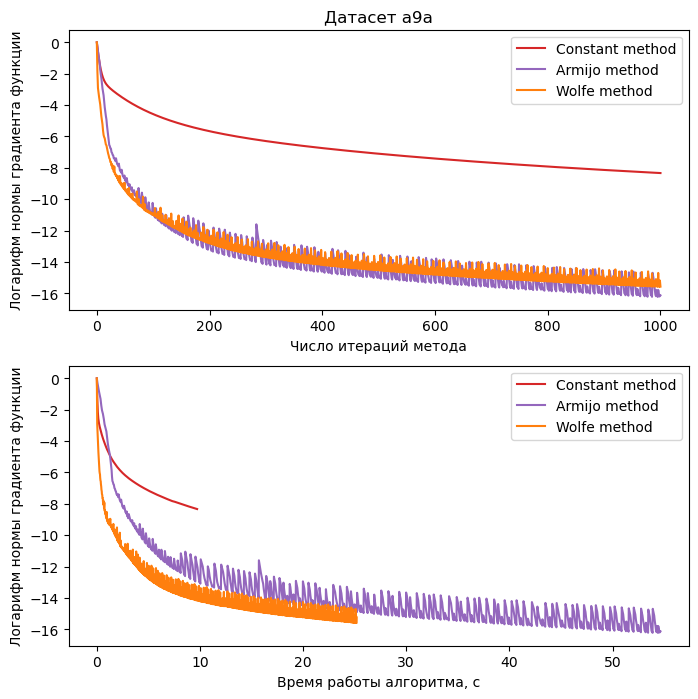

In [29]:
criterion, history = plot_logreg(AX, ay, parameters, 1000, 'a9a')

Для датасета a9a видно, что быстрее всего по времени работает метод Вульфа. На графике можно увидеть, что число итераций, необходимых методу Армихо, меньше чем для метода Вульфа для достижения того же значения точности (нормы градиента, которая сравнивается с критерием останова на каждой итерации), однако каждая итерация значительно дольше, в итоге метод работает в 2 раза дольше, но не значительно лучше. Метод градиентного спуска с постоянным шагом сходится еще медленнее, но каждая итерация данного метода быстрее других двух методов. Тем не менее за 1000 итераций сходимость метода не достигла той же точности, что в других методах. Метод Армихо является самым медленным с точки зрения времени работы алгоритма. 

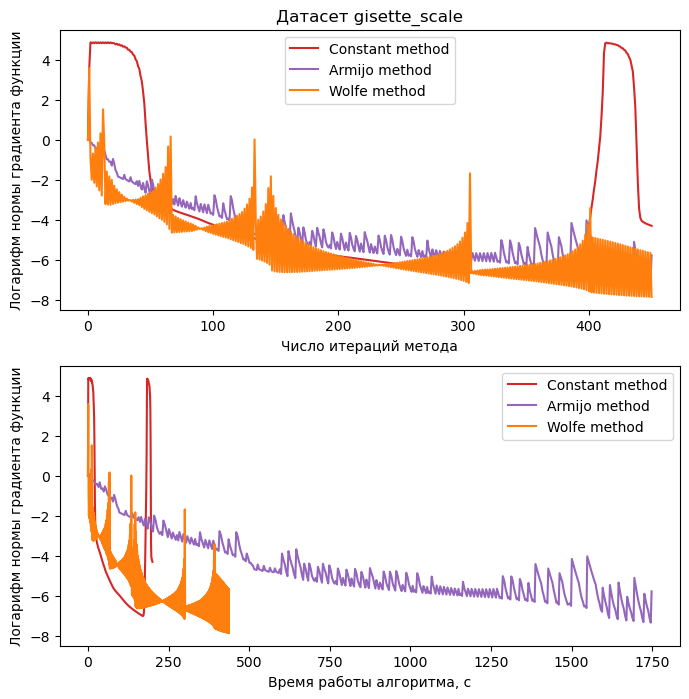

In [13]:
criterion, history = plot_logreg(GX, gy, parameters, 450, 'gisette_scale')

В случае датасета gisette можно увидеть, что метод Армихо медленнее достигает почти того же значения нормы градиента функции, что и метод Вульфа. Метод градиентного спуска с постоянным шагом сходится чуть быстрее метода Вульфа, но из-за плохо подобранной константы не может сойтись - возникают волны на графике. В данном случае размер данных сильнее влияет на время работы метода - метод Армихо работает более чем в 3 раза дольше, чем Вульф. Можно сделать вывод, что чем больше данных в датасете, тем более значимой является разница в методах. 

/opt/conda/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


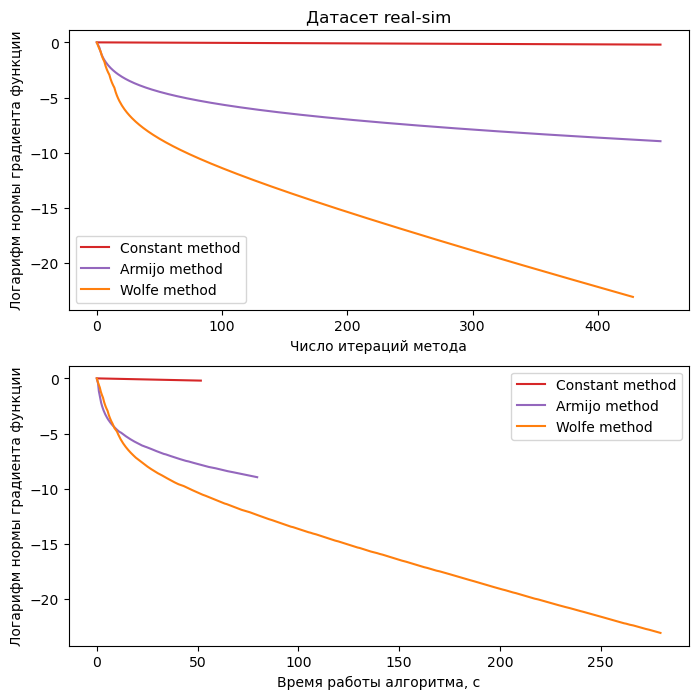

In [10]:
criterion, history = plot_logreg(SX, sy, parameters, 450, 'real-sim')

Кажется, что при большом числе данных метод Вульфа работает наиболее приемлимо - аналогичная точность достигается наименьшим числом итераций и временем работы алгоритма. 